# Part II: Road Lane Detection Using Hough Transform

## Imports

In [1]:
import requests
import os

import cv2
import numpy as np
import math

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

## Utilities

Getting image from url

In [2]:
def download_image(image_url, image_name):
  image_data = requests.get(image_url).content
  with open(image_name, 'wb') as handler:
    handler.write(image_data)
  return os.path.join(os.getcwd(), image_name)

## Downloading and Displaying Image

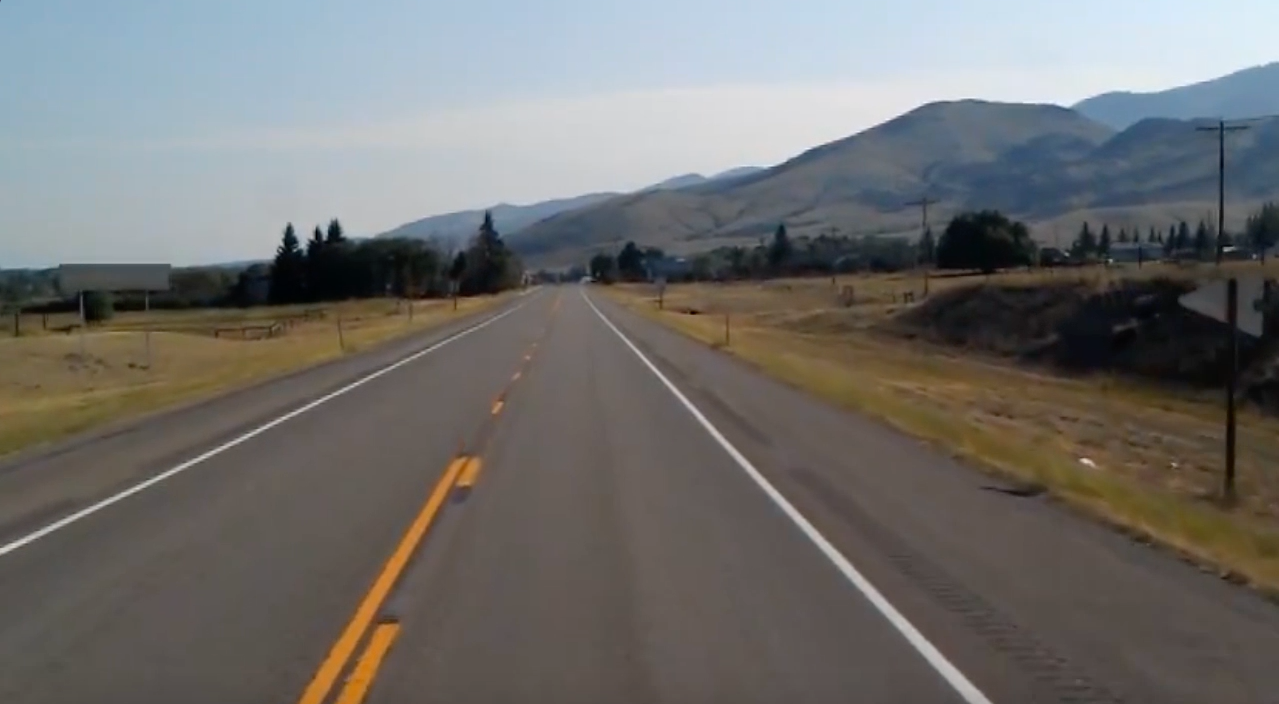

In [3]:
image_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/ImageCartoonifying-and-LaneDetection/master/assets/part2/road_lanes.png'
image_name = 'part2_image.png'
image_path = download_image(image_url, image_name)

colored_image = cv2.imread(image_path)
gray_image = cv2.imread(image_path, 0)
cv2_imshow(colored_image)

## Lane Detection Steps

### 1. Smoothing The Image

Applying the median filter with size 5 x 5


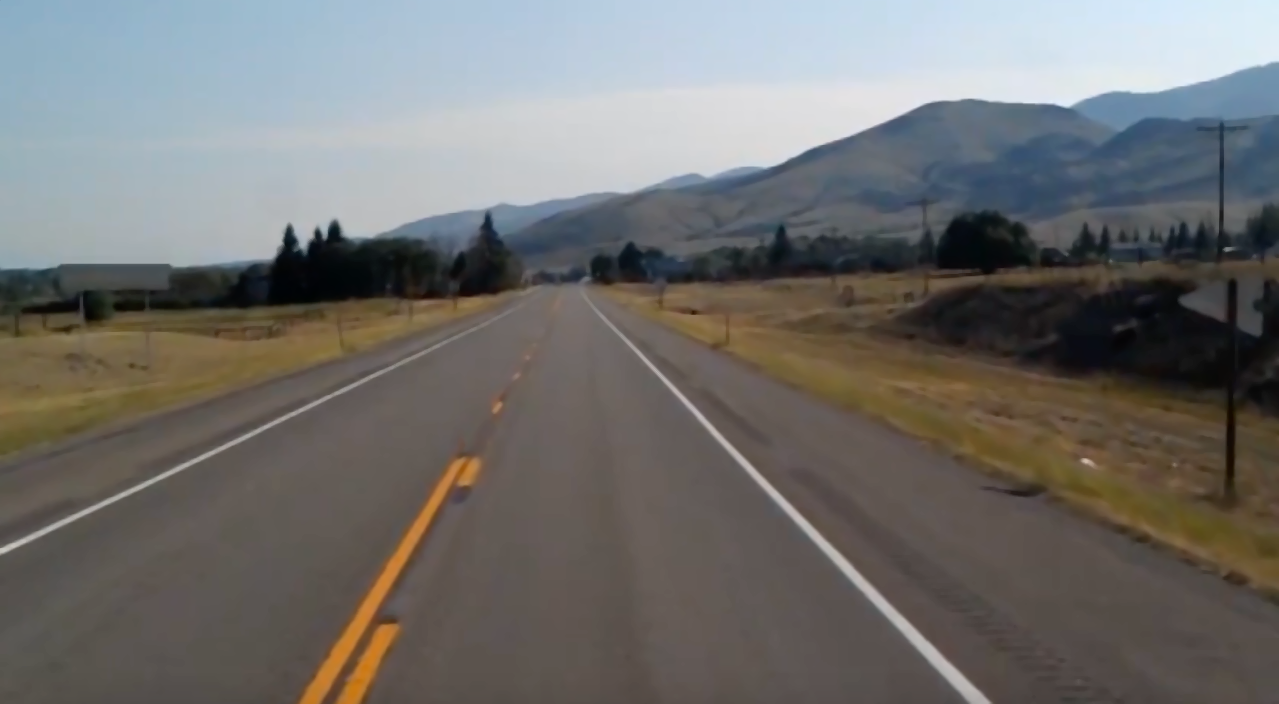

In [4]:
smoothed_image = cv2.medianBlur(colored_image, 5)
cv2_imshow(smoothed_image)

### 2. Edge Detection

 Detecting edges and thresholding using Canny's edge detector

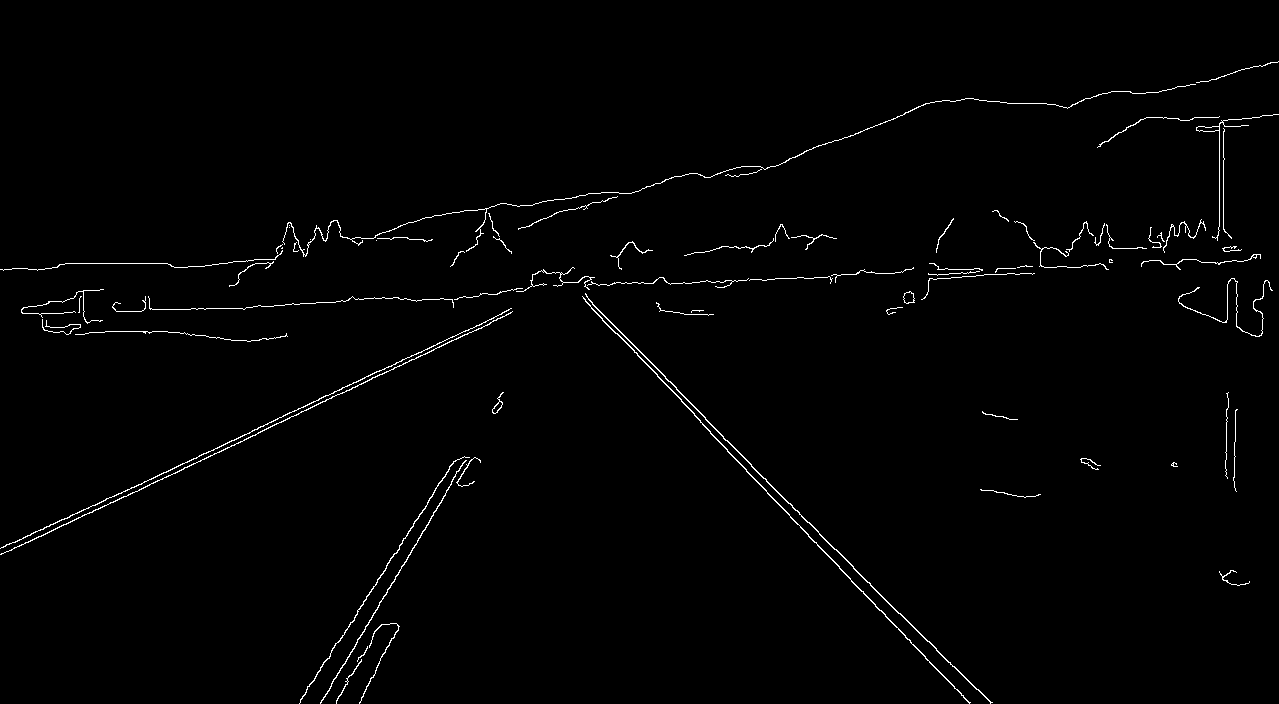

In [5]:
edges_image = cv2.Canny(smoothed_image, 50, 150)
cv2_imshow(edges_image)

### 3. Region Of Interest

*   The edges resulted contains some un-necessaries related to the objects outside the road
*   We define the ROI by defining the coordinated of the vertieces of the polyogn

*  After that we mask the polygon with the edges to obtain only the edges belongs to lanes of the road

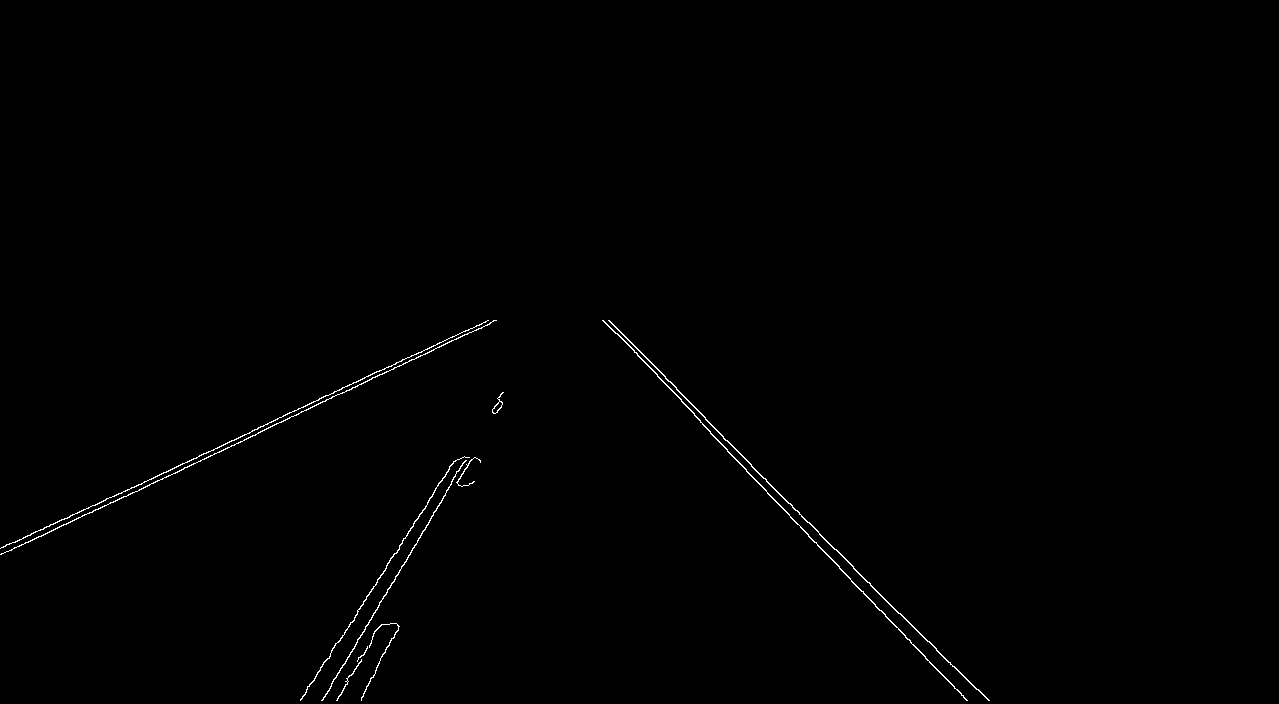

In [6]:
# Defining the vertices of the polygon for the region of interest
roi_vertices = np.array([[(0, 700), (0, 450), (420, 320), (800, 320), (1000, 700)]])

# Creating a mask to apply to the edges image
mask = np.zeros_like(edges_image)
cv2.fillPoly(mask, roi_vertices, 255)

# Applying the masking
masked_edges_image = cv2.bitwise_and(edges_image, mask)

cv2_imshow(masked_edges_image)

### 4. Hough Transform

**In this part we apply the Hough Transform by accumulation on (rho, theta)**


Steps



1.   Construct the accumulator array with height = 2 * max rho, beacuse rho can be positive or negative and width = max theta.
2.   For all points the belongs to an edge, we compute rho for all theta that ranges from 0 to 180.
3.   After that we increase the votes at theta and the computed rho.
4.   After accumultationg on rho and theta we threshold the accumulator array at 220 because the points in accumulator array that has the maxmium votes represents the parameters of the actual lines on the image.
5.   Finally, we perofrm non max supression to remove duplicate detections.



In [7]:
height, width = masked_edges_image.shape[:2]

# Defining the max possilbe row to equal the diagonal of the image
max_rho = math.ceil(np.linalg.norm((height, width)))
max_theta = 180

# Defining the size of the acculmulator array to equal X [-max rho : max rho], Y [0 : 180] i.e (2 * max_rho, max_theta + 1)
acc = np.zeros((2 * max_rho, max_theta + 1))

# For each point that belong to edge compute rho when theta ranges from 0 to 180
for y, x in zip(*np.where(masked_edges_image == 255)):
    for theta in range(0,  max_theta + 1):

        rho = round(x * np.cos(np.deg2rad(theta)) + y * np.sin(np.deg2rad(theta)))

        # Increasing the votes in the accumulator array
        acc[max_rho - rho, theta] = acc[max_rho - rho, theta] + 1

### 5. Refining Coordinates and HT Post-Processing

Steps
1.   After accumultationg on rho and theta we threshold the accumulator array at 220 because the points in accumulator array that has the maxmium votes represents the parameters of the actual lines on the image.
2.   Finally, we perofrm non max supression to remove duplicate detections.

**Non-Maximum Suppression:**
A post processing technique used to remove the duplicate detections and select the most relevant lines by choosing the local maximum and eliminating surrounding noisy predections


**Input**  the thresholded accumulator array that has proposal lines, the size of the sliding window

**Output** the filtered accumulator array

**Steps**

1. Perform padding on the accumulator array, so we can slide a window a long all pixels of the accumulator array and compare them with their neighbours.

2. for each pixel that represnet an anchor for the sliding window we check the following:

      * if the pixel value is larger than all neighbours, then store it in the resulted filtered accumulator array as a predicted line

      * if not then ignore it and doesn't store it as a predicted line in the filtered accumulator array

In [8]:
def non_max_suppression(prediction, kernel_size):
    height, width = prediction.shape[:2]
    result = np.zeros_like(prediction)

    prediction = np.pad(prediction, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2)), mode='constant', constant_values=0)

    for x in range(kernel_size // 2, height + kernel_size // 2):
        for y in range(kernel_size // 2, width + kernel_size // 2):
            if prediction[x, y] >= np.max(prediction[x - kernel_size // 2: x + kernel_size // 2 + 1, y - kernel_size // 2: y + kernel_size // 2 + 1]) \
                and prediction[x, y] > 0:
                result[x - kernel_size // 2, y - kernel_size // 2] = 255
            else:
                result[x - kernel_size // 2, y - kernel_size // 2] = 0

    return result

In [9]:
# Thresholding the accumulator array at 220
thresh_acc = acc.copy()
thresh_acc[thresh_acc <= 220] = 0

# Preforming non max suppression to remove noisy lines
thresh_acc = non_max_suppression(thresh_acc, 7)

# Converting the acculumator array indecies at the max votes to the actual rho and theta
lines = np.argwhere(thresh_acc == 255).astype(np.float64)
lines[:, 0] = max_rho - lines[:, 0]
lines[:, 1] = np.deg2rad(lines[:, 1])

Plotting the accumulator array

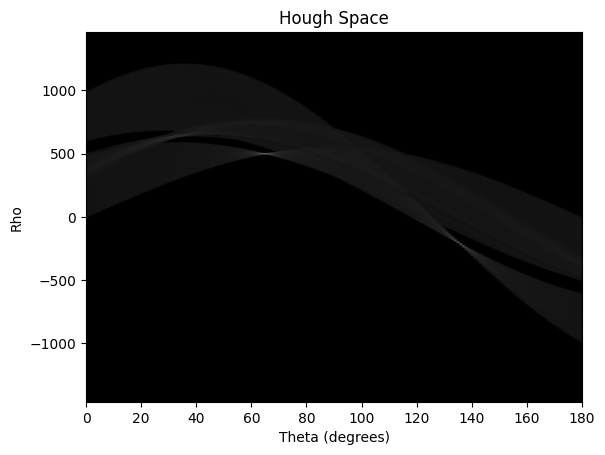

In [10]:
# Increasing the brightness
acc[acc > 0] += 25

plt.imshow(acc, cmap='gray', extent=[0, max_theta, -max_rho, max_rho],  aspect='auto')

plt.xlabel('Theta (degrees)')
plt.ylabel('Rho')
plt.title('Hough Space')

plt.show()

In this part we draw the lines obtained from Hough Transform

**steps**




1.   At first, we compute the coordinates of the intersection between the line resulted from the hough transform and the perpendicular line from the origin.

2.   Secondly, we extend the line in two directions to compute two points to be able to draw the line.

3.  Thirdly, we determine the ROI to clip lines drawn on the image



In [11]:
def draw_line(image, lines, roi_vertices, thickness=2):
    image_with_lines = np.zeros_like(image)

    # Creating a mask to apply to the drawn lines
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, roi_vertices, 255)

    extension_length = max(image_with_lines.shape[0], image_with_lines.shape[1])

    for (rho, theta) in lines:
      a = np.cos(theta)
      b = np.sin(theta)

      x0 = a * rho
      y0 = b * rho

      x1 = int(x0 + extension_length * b)
      y1 = int(y0 + extension_length * -a)
      x2 = int(x0 - extension_length * b)
      y2 = int(y0 - extension_length * -a)

      cv2.line(image_with_lines, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=thickness)

    # Applying the mask
    masked_lines = cv2.bitwise_and(image_with_lines[:, :, 1], mask[:, :, 0])

    # Adding masked lines to the original image's green channel
    image_with_masked_lines = image.copy()
    image_green_channel = image_with_masked_lines[:, :, 1]
    image_green_channel[masked_lines > 0] = 255
    image_with_masked_lines[:, :, 1] = image_green_channel

    cv2_imshow(image_with_masked_lines)

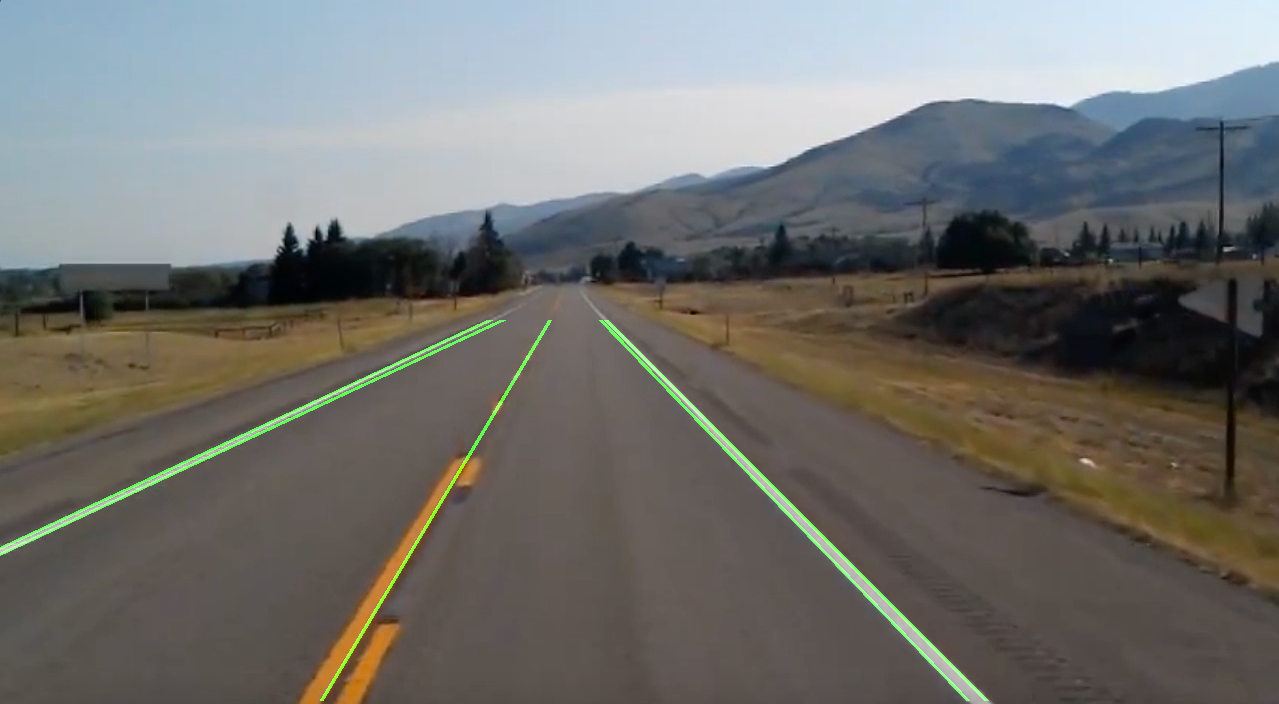

In [12]:
draw_line(colored_image, lines, roi_vertices)